/tmp/ipykernel_7859/309779108.py:97: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10")


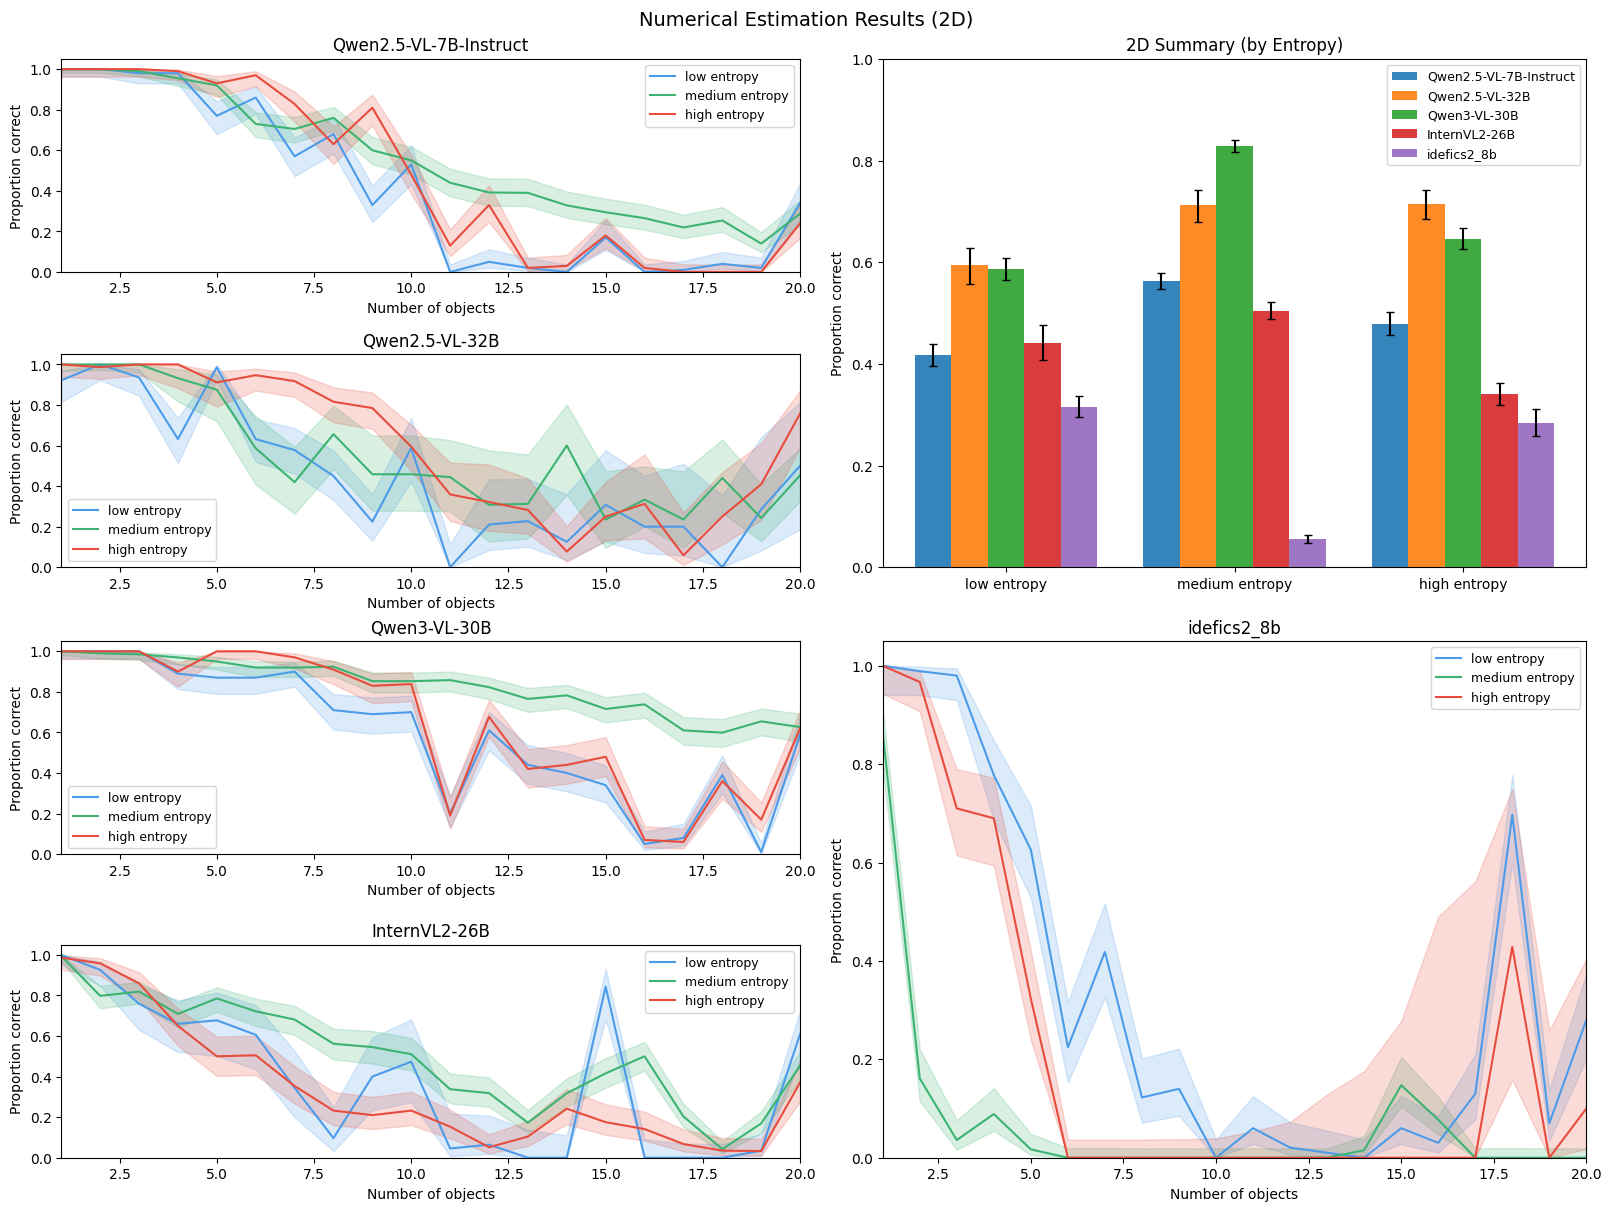

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ----------------------------
# Binomial 95% CI (Wilson)
# ----------------------------
def wilson_ci(k, n, z=1.96):
    k = np.asarray(k, dtype=float)
    n = np.asarray(n, dtype=float)
    low = np.zeros_like(k)
    high = np.zeros_like(k)

    mask = n > 0
    phat = np.zeros_like(k)
    phat[mask] = k[mask] / n[mask]

    denom = 1 + (z**2) / n[mask]
    center = (phat[mask] + (z**2) / (2*n[mask])) / denom
    half = (z / denom) * np.sqrt((phat[mask]*(1 - phat[mask]) + (z**2) / (4*n[mask])) / n[mask])

    low[mask] = np.clip(center - half, 0, 1)
    high[mask] = np.clip(center + half, 0, 1)
    return low, high


# ----------------------------
# Condition mapping + pooling
# ----------------------------
def map_entropy(lbl):
    if lbl == "low_entropy":
        return "low_entropy"
    if lbl == "high_entropy":
        return "high_entropy"
    if lbl in ("medium_entropy_same_shape", "medium_entropy_same_color"):
        return "medium_entropy"
    return None  # ignore control_distinct by default


def prepare_pooled(df_raw, model_name):
    df = df_raw.copy()
    df["model"] = model_name
    df["entropy_group"] = df["condition_label"].map(map_entropy)
    df = df[df["entropy_group"].notnull()].copy()

    # Pool duplicates by (model, entropy_group, n_objects)
    pooled = (
        df.groupby(["model", "entropy_group", "n_objects"], as_index=False)[["n_trials", "n_correct"]]
          .sum()
          .sort_values(["entropy_group", "n_objects"])
    )
    pooled["accuracy"] = pooled["n_correct"] / pooled["n_trials"]
    lo, hi = wilson_ci(pooled["n_correct"].values, pooled["n_trials"].values)
    pooled["ci_low"] = lo
    pooled["ci_high"] = hi
    return pooled


def summary_by_entropy(pooled_one_model):
    # Pool across n_objects -> single accuracy per entropy level for this model
    summ = (
        pooled_one_model.groupby(["model", "entropy_group"], as_index=False)[["n_trials", "n_correct"]]
                        .sum()
    )
    summ["accuracy"] = summ["n_correct"] / summ["n_trials"]
    lo, hi = wilson_ci(summ["n_correct"].values, summ["n_trials"].values)
    summ["ci_low"] = lo
    summ["ci_high"] = hi
    return summ


# ----------------------------
# Plotting
# ----------------------------
def plot_numerical_estimation(model_dfs, title="Numerical Estimation Results (2D)"):
    """Layout:
      - Left column: first 4 models (stacked line plots)
      - Right column: vertical summary bar chart (top) + last model line plot (bottom)
    """
    if not model_dfs:
        raise ValueError("model_dfs is empty")

    model_names = list(model_dfs.keys())
    n_models = len(model_names)

    pooled = {name: prepare_pooled(df, name) for name, df in model_dfs.items()}
    summ = pd.concat([summary_by_entropy(p) for p in pooled.values()], ignore_index=True)

    entropy_order = ["low_entropy", "medium_entropy", "high_entropy"]
    entropy_label = {
        "low_entropy": "low entropy",
        "medium_entropy": "medium entropy",
        "high_entropy": "high entropy",
    }

    cmap = plt.cm.get_cmap("tab10")
    model_colors = {name: cmap(i % 10) for i, name in enumerate(model_names)}

    entropy_line_colors = {
        "low_entropy": "#4C9BE8",
        "medium_entropy": "#3CB371",
        "high_entropy": "#E74C3C",
    }

    # ---- Decide who goes where (assumes 5 models: 4 left, 1 right) ----
    left_models = model_names[:4]
    right_model = model_names[4] if n_models >= 5 else (model_names[-1] if n_models else None)

    # ---- Figure + Grid ----
    # 4 rows total. Right column: bar spans rows 0-1, model spans rows 2-3
    fig = plt.figure(figsize=(16, 12), constrained_layout=True)
    gs = fig.add_gridspec(
        4, 2,
        width_ratios=[1.05, 1.0],
        height_ratios=[1, 1, 1, 1]
    )
    fig.suptitle(title, fontsize=14)

    # Left column axes (4 model plots)
    ax_left = [fig.add_subplot(gs[r, 0]) for r in range(4)]

    # Right column axes
    ax_bar = fig.add_subplot(gs[0:2, 1])       # top half
    ax_right_model = fig.add_subplot(gs[2:4, 1])  # bottom half

    # ---- Vertical summary bar chart ----
    x_base = np.arange(len(entropy_order))
    bar_w = 0.8 / max(n_models, 1)
    offsets = (np.arange(n_models) - (n_models - 1) / 2.0) * bar_w

    for i, model_name in enumerate(model_names):
        sub = summ[summ["model"] == model_name].set_index("entropy_group")

        accs, el, eh = [], [], []
        for g in entropy_order:
            a = float(sub.loc[g, "accuracy"]) if g in sub.index else np.nan
            lo = float(sub.loc[g, "ci_low"]) if g in sub.index else np.nan
            hi = float(sub.loc[g, "ci_high"]) if g in sub.index else np.nan
            accs.append(a)
            el.append(a - lo if np.isfinite(a) else np.nan)
            eh.append(hi - a if np.isfinite(a) else np.nan)

        x = x_base + offsets[i]
        ax_bar.bar(
            x,
            accs,
            width=bar_w,
            yerr=np.vstack([el, eh]),
            color=model_colors[model_name],
            alpha=0.9,
            capsize=3,
            label=model_name,
        )

    ax_bar.set_xticks(x_base)
    ax_bar.set_xticklabels([entropy_label[g] for g in entropy_order], rotation=0)
    ax_bar.set_ylim(0, 1.0)
    ax_bar.set_ylabel("Proportion correct")
    ax_bar.set_title("2D Summary (by Entropy)")
    ax_bar.legend(frameon=True, fontsize=9, ncol=1)

    # ---- Helper to draw one model line-plot into an axis ----
    def draw_model_lines(ax, model_name):
        p = pooled[model_name]
        for g in entropy_order:
            sub = p[p["entropy_group"] == g].sort_values("n_objects")
            if sub.empty:
                continue
            x = sub["n_objects"].values
            y = sub["accuracy"].values
            lo = sub["ci_low"].values
            hi = sub["ci_high"].values
            ax.plot(x, y, label=entropy_label[g], color=entropy_line_colors[g])
            ax.fill_between(x, lo, hi, color=entropy_line_colors[g], alpha=0.2)

        ax.set_xlim(1, 20)
        ax.set_ylim(0, 1.05)
        ax.set_xlabel("Number of objects")
        ax.set_ylabel("Proportion correct")
        ax.set_title(model_name)
        ax.legend(frameon=True, fontsize=9)

    # ---- Left column: up to 4 models ----
    for ax, m in zip(ax_left, left_models):
        draw_model_lines(ax, m)

    # Turn off unused left axes if <4 models
    for ax in ax_left[len(left_models):]:
        ax.axis("off")

    # ---- Right column bottom: remaining model (if exists) ----
    if right_model is not None and right_model not in left_models:
        draw_model_lines(ax_right_model, right_model)
    else:
        ax_right_model.axis("off")

    plt.savefig("./analysis/plots/numerical_estimation_tasks.pdf", format="pdf", bbox_inches="tight")
    plt.show()

# ----------------------------
# Example usage
# ----------------------------
BASE = Path("analysis/results/2D")
model_paths = {
    "Qwen2.5-VL-7B-Instruct": BASE / "qwen2.5-VL-7B-Instruct_counting.csv",
    "Qwen2.5-VL-32B": BASE / "qwen2.5-VL-32B-Instruct-AWQ_counting.csv",
    "Qwen3-VL-30B": BASE / "qwen3-vl-30b-a3b-instruct_counting.csv",
    "InternVL2-26B": BASE / "InternVL2-26B_counting.csv",
    "idefics2_8b": BASE / "idefics2_8b_counting.csv",
}

model_dfs = {name: pd.read_csv(path) for name, path in model_paths.items()}
plot_numerical_estimation(model_dfs)


/tmp/ipykernel_7859/3529895256.py:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10")


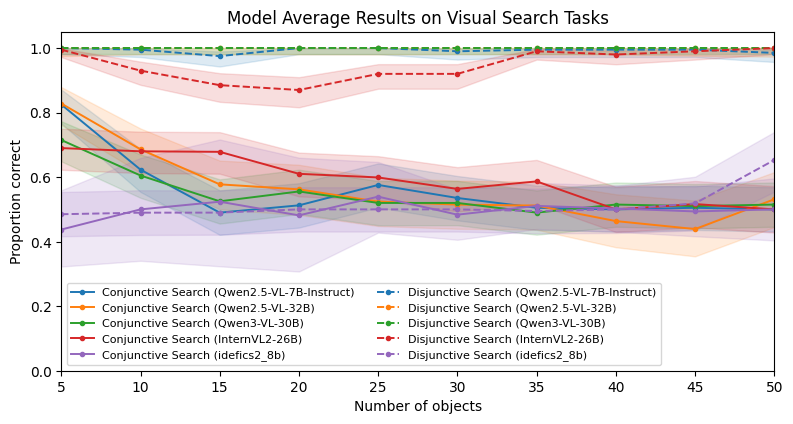

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ----------------------------
# Binomial 95% CI (Wilson)
# ----------------------------
def wilson_ci(k, n, z=1.96):
    k = np.asarray(k, dtype=float)
    n = np.asarray(n, dtype=float)
    low = np.zeros_like(k)
    high = np.zeros_like(k)

    mask = n > 0
    phat = np.zeros_like(k)
    phat[mask] = k[mask] / n[mask]

    denom = 1 + (z**2) / n[mask]
    center = (phat[mask] + (z**2) / (2*n[mask])) / denom
    half = (z / denom) * np.sqrt((phat[mask]*(1 - phat[mask]) + (z**2) / (4*n[mask])) / n[mask])

    low[mask] = np.clip(center - half, 0, 1)
    high[mask] = np.clip(center + half, 0, 1)
    return low, high


# ----------------------------
# Load + prepare visual-search results
# ----------------------------
def load_visual_search_csv(path, model_name):
    def empty_frame():
        return pd.DataFrame({
            "model": pd.Series(dtype=str),
            "condition_label": pd.Series(dtype=str),
            "n_objects": pd.Series(dtype=int),
            "n_trials": pd.Series(dtype=int),
            "n_correct": pd.Series(dtype=int),
            "accuracy": pd.Series(dtype=float),
            "ci_low": pd.Series(dtype=float),
            "ci_high": pd.Series(dtype=float),
        })

    df = pd.read_csv(path)
    if df.empty:
        out = empty_frame()
        out["model"] = out["model"].astype(str)
        return out

    df["model"] = model_name

    # Robust numeric parsing (some CSVs can be empty or have object dtypes)
    for col in ["n_objects", "n_trials", "n_correct"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    required = ["condition_label", "n_objects", "n_trials", "n_correct"]
    for col in required:
        if col not in df.columns:
            return empty_frame()

    df = df.dropna(subset=required).copy()
    if df.empty:
        return empty_frame()

    df["n_objects"] = df["n_objects"].astype(int)
    df["n_trials"] = df["n_trials"].astype(int)
    df["n_correct"] = df["n_correct"].astype(int)

    # Keep only main conditions (drop disjunctive_control unless you want it)
    df = df[df["condition_label"].isin(["disjunctive", "conjunctive"])].copy()
    if df.empty:
        return empty_frame()

    # Aggregate in case there are duplicates
    df = (
        df.groupby(["model", "condition_label", "n_objects"], as_index=False)[["n_trials", "n_correct"]]
          .sum()
          .sort_values(["condition_label", "n_objects"])
    )
    df["accuracy"] = (df["n_correct"] / df["n_trials"]).astype(float)
    lo, hi = wilson_ci(df["n_correct"].values, df["n_trials"].values)
    df["ci_low"] = lo.astype(float)
    df["ci_high"] = hi.astype(float)
    return df


def plot_visual_search_multi_models(df_all, title="Model Average Results on Visual Search Tasks"):
    cond_order = ["conjunctive", "disjunctive"]
    cond_label = {"conjunctive": "Conjunctive Search", "disjunctive": "Disjunctive Search"}
    cond_style = {"conjunctive": "-", "disjunctive": "--"}

    models = list(df_all["model"].unique())
    cmap = plt.cm.get_cmap("tab10")
    model_colors = {m: cmap(i % 10) for i, m in enumerate(models)}

    fig, ax = plt.subplots(figsize=(9.2, 4.4))

    for cond in cond_order:
        for model in models:
            sub = df_all[(df_all["condition_label"] == cond) & (df_all["model"] == model)].sort_values("n_objects")
            if sub.empty:
                continue

            x = sub["n_objects"].to_numpy()
            y = sub["accuracy"].astype(float).to_numpy()
            lo = sub["ci_low"].astype(float).to_numpy()
            hi = sub["ci_high"].astype(float).to_numpy()

            color = model_colors[model]
            ax.plot(
                x,
                y,
                color=color,
                linestyle=cond_style[cond],
                marker="o",
                markersize=3,
                linewidth=1.4,
                label=f"{cond_label[cond]} ({model})",
            )
            ax.fill_between(x, lo, hi, color=color, alpha=0.15)

    ax.set_title(title)
    ax.set_xlabel("Number of objects")
    ax.set_ylabel("Proportion correct")
    ax.set_xlim(df_all["n_objects"].min(), df_all["n_objects"].max())
    ax.set_ylim(0.0, 1.05)
    ax.legend(frameon=True, fontsize=8, ncol=2)
    plt.savefig("./analysis/plots/vusial_search_tasks.pdf", format="pdf", bbox_inches="tight")
    plt.show()


# ----------------------------
# Paths (update if needed)
# ----------------------------
BASE = Path("analysis/results/2D")
model_paths = {
    "Qwen2.5-VL-7B-Instruct": BASE / "qwen2.5-VL-7B-Instruct_visual_search.csv",
    "Qwen2.5-VL-32B": BASE / "qwen2.5-VL-32B-Instruct-AWQ_visual_search.csv",
    "Qwen3-VL-30B": BASE / "qwen3-vl-30b-a3b-instruct_visual_search.csv",
    "InternVL2-26B": BASE / "InternVL2-26B_visual_search.csv",
    "idefics2_8b": BASE / "idefics2_8b_visual_search.csv",
}

all_dfs = [load_visual_search_csv(path, model_name=name) for name, path in model_paths.items()]
df_all = pd.concat(all_dfs, ignore_index=True)

plot_visual_search_multi_models(df_all)


/tmp/ipykernel_7859/3964013435.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10")


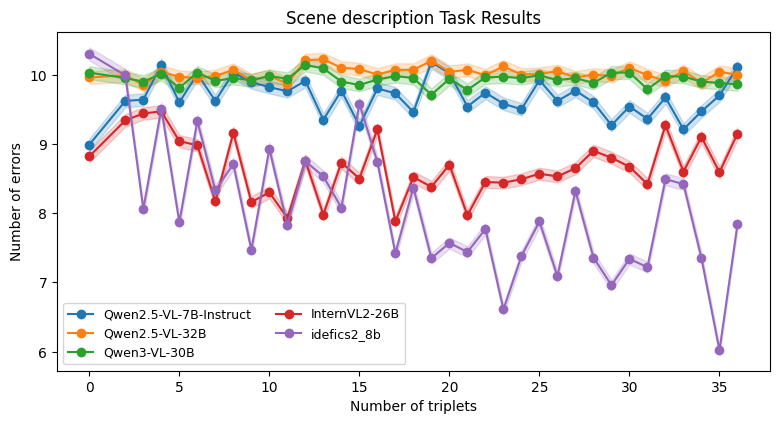

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ----------------------------
# Load + prep
# ----------------------------
def load_scene_desc(path, model_name):
    df = pd.read_csv(path)
    df["model"] = model_name

    # Aggregate in case of duplicates
    df = (
        df.groupby(["model", "gt_triplets"], as_index=False)[["n_trials", "mean_errors"]]
          .mean()  # mean_errors is already a mean; duplicates are unlikely, but safe
          .sort_values("gt_triplets")
    )
    return df


def add_approx_ci(df, z=1.96):
    """
    You only have mean_errors + n_trials (no std/sem), so we can't compute a true CI.
    As a lightweight stand-in (for a shaded band like the reference figure),
    we use a normal-approximation for the mean with an assumed Bernoulli-like bound:
        CI ~ mean ± z * sqrt(mean*(1-mean)/n)
    This is NOT statistically correct for edit-distance errors, but gives a small band.
    If you have per-example errors, replace this with the true SEM.
    """
    out = df.copy()
    # keep values non-negative for the sqrt; also avoid division by 0
    n = np.maximum(out["n_trials"].values.astype(float), 1.0)
    m = out["mean_errors"].values.astype(float)

    # Very small band fallback (so it still "looks" like the style)
    # Scale factor keeps band visible but not huge; adjust if you want.
    band = z * (np.sqrt(np.maximum(m, 1e-8)) / np.sqrt(n)) * 0.15

    out["ci_low"] = np.maximum(m - band, 0)
    out["ci_high"] = m + band
    return out


# ----------------------------
# Plot (style like your example)
# ----------------------------
def plot_scene_description(dfs, title="Scene description Task Results"):
    models = [df["model"].iloc[0] for df in dfs]
    cmap = plt.cm.get_cmap("tab10")
    colors = {m: cmap(i % 10) for i, m in enumerate(models)}

    fig, ax = plt.subplots(figsize=(9.2, 4.4))

    for df in dfs:
        model = df["model"].iloc[0]
        df = df.sort_values("gt_triplets")
        x = df["gt_triplets"].values
        y = df["mean_errors"].values
        lo = df["ci_low"].values
        hi = df["ci_high"].values

        ax.plot(x, y, marker="o", linewidth=1.5, label=model, color=colors[model])
        ax.fill_between(x, lo, hi, color=colors[model], alpha=0.2)

    ax.set_title(title)
    ax.set_xlabel("Number of triplets")
    ax.set_ylabel("Number of errors")
    ax.legend(frameon=True, fontsize=9, ncol=2)
    plt.savefig("./analysis/plots/scene_description_tasks.pdf", format="pdf", bbox_inches="tight")
    plt.show()


# ----------------------------
# Paths (same folder you used before)
# ----------------------------
BASE = Path("analysis/results/2D")
model_paths = {
    "Qwen2.5-VL-7B-Instruct": BASE / "qwen2.5-VL-7B-Instruct_scene_description.csv",
    "Qwen2.5-VL-32B": BASE / "qwen2.5-VL-32B-Instruct-AWQ_scene_description.csv",
    "Qwen3-VL-30B": BASE / "qwen3-vl-30b-a3b-instruct_scene_description.csv",
    "InternVL2-26B": BASE / "InternVL2-26B_scene_description.csv",
    "idefics2_8b": BASE / "idefics2_8b_scene_description.csv",
}

all_dfs = [add_approx_ci(load_scene_desc(path, name)) for name, path in model_paths.items()]

# NOTE: shaded bands are approximate unless you have per-trial error distributions
plot_scene_description(all_dfs)


In [7]:
import pandas as pd
import numpy as np
from pathlib import Path

# ----------------------------
# 1) Wilson 95% CI for binomial accuracy
# ----------------------------
def wilson_ci(k: int, n: int, z: float = 1.96):
    """
    Wilson score interval for a binomial proportion.
    Returns (low, high) in [0,1].
    """
    if n == 0:
        return 0.0, 0.0
    p = k / n
    denom = 1.0 + (z**2) / n
    center = (p + (z**2) / (2*n)) / denom
    half = (z / denom) * np.sqrt((p*(1-p) / n) + (z**2) / (4*n**2))
    return max(0.0, center - half), min(1.0, center + half)


def add_ci_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    lows, highs = [], []
    for k, n in zip(df["n_correct"].astype(int), df["n_trials"].astype(int)):
        lo, hi = wilson_ci(k, n)
        lows.append(lo)
        highs.append(hi)
    df["ci_low"] = lows
    df["ci_high"] = highs
    return df


# ----------------------------
# 2) Load RMTS CSVs and compute CIs
# ----------------------------
BASE = Path("analysis/results/2D")  # adjust if needed

paths = {
    "Qwen3-VL-30B": BASE / "qwen3-vl-30b-a3b-instruct_rmts.csv",
    "Qwen2.5-VL-32B": BASE / "qwen2.5-VL-32B-Instruct-AWQ_rmts.csv",
    "Qwen2.5-VL-7B-Instruct": BASE / "qwen2.5-VL-7B-Instruct_rmts.csv",
    "InternVL2-26B": BASE / "InternVL2-26B_rmts.csv",
    "idefics2_8b": BASE / "idefics2_8b_rmts.csv",
}

dfs = {}
for model_name, path in paths.items():
    df = pd.read_csv(path)
    # Normalize expected columns
    required = {"condition", "subtask", "n_trials", "n_correct", "accuracy"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"{model_name}: missing columns {missing} in {path}")

    # Recompute accuracy from counts to avoid any rounding issues
    df["accuracy"] = df["n_correct"] / df["n_trials"]

    df = add_ci_columns(df)
    df["model"] = model_name
    dfs[model_name] = df

    # Optional: write an intermediate CSV with CI values (for debugging/reproducibility)
    out_csv = path.with_name(path.stem + "_with_ci.csv")
    df.to_csv(out_csv, index=False)
    print(f"Wrote: {out_csv}")


# ----------------------------
# 3) Convert to the paper-style LaTeX table (Unified vs Decomposed)
# ----------------------------
SUBTASK_ROWNAME = {
    "full": "Analogy (full)",
    "relations": "Relation decoding",
    "features": "Full feature decoding",
    "features2": "Single feature decoding",
}
ROW_ORDER = ["full", "relations", "features", "features2"]


def fmt_pct(p: float) -> str:
    return f"{int(round(100*p))}\\%"


def fmt_ci(lo: float, hi: float) -> str:
    return f"({int(round(100*lo))}\\%, {int(round(100*hi))}\\%)"


def make_latex_table_for_model(df: pd.DataFrame, model_caption_name: str) -> str:
    # Pivot unified/decomposed into columns
    # Ensure we have exactly one row per (condition, subtask)
    df = df.copy()
    df["condition"] = df["condition"].str.lower()
    df["subtask"] = df["subtask"].str.lower()

    # Build lookup dict: (condition, subtask) -> row
    lookup = {(r["condition"], r["subtask"]): r for _, r in df.iterrows()}

    rows = []
    for st in ROW_ORDER:
        unified = lookup.get(("unified", st), None)
        decomposed = lookup.get(("decomposed", st), None)

        if unified is None or decomposed is None:
            raise ValueError(f"Missing unified/decomposed for subtask='{st}' in model='{model_caption_name}'")

        u_acc = unified["accuracy"]
        u_lo, u_hi = unified["ci_low"], unified["ci_high"]
        d_acc = decomposed["accuracy"]
        d_lo, d_hi = decomposed["ci_low"], decomposed["ci_high"]

        # Bold the higher accuracy column (ties: bold both)
        u_acc_tex = fmt_pct(u_acc)
        d_acc_tex = fmt_pct(d_acc)
        if abs(u_acc - d_acc) < 1e-12:
            u_acc_tex = f"\\textbf{{{u_acc_tex}}}"
            d_acc_tex = f"\\textbf{{{d_acc_tex}}}"
        elif d_acc > u_acc:
            d_acc_tex = f"\\textbf{{{d_acc_tex}}}"
        else:
            u_acc_tex = f"\\textbf{{{u_acc_tex}}}"

        row_name = SUBTASK_ROWNAME.get(st, st)
        rows.append(
            f"{row_name} & {u_acc_tex} & {fmt_ci(u_lo, u_hi)} & {d_acc_tex} & {fmt_ci(d_lo, d_hi)} \\\\"
        )

    latex = "\n".join([
        "\\begin{table}[t]",
        "\\centering",
        f"\\caption{{Visual analogy results: {model_caption_name}.}}",
        "\\begin{tabular}{lcccc}",
        "\\toprule",
        " & \\multicolumn{2}{c}{Unified Accuracy} & \\multicolumn{2}{c}{Decomposed Accuracy} \\\\",
        "\\cmidrule(lr){2-3} \\cmidrule(lr){4-5}",
        " & Accuracy & 95\\% CI & Accuracy & 95\\% CI \\\\",
        "\\midrule",
        *rows,
        "\\bottomrule",
        "\\end{tabular}",
        "\\end{table}",
    ])
    return latex


# Generate LaTeX for each model and save to .tex files
out_tex_dir = BASE / "latex_tables"
out_tex_dir.mkdir(parents=True, exist_ok=True)

for model_name, df in dfs.items():
    latex = make_latex_table_for_model(df, model_name)
    out_path = out_tex_dir / f"{model_name.replace(' ', '_').replace('.', '')}_rmts_table.tex"
    out_path.write_text(latex, encoding="utf-8")
    print(f"\n--- LaTeX table for {model_name} ---\n")
    print(latex)
    print(f"\nSaved to: {out_path}\n")


Wrote: analysis/results/2D/qwen3-vl-30b-a3b-instruct_rmts_with_ci.csv
Wrote: analysis/results/2D/qwen2.5-VL-32B-Instruct-AWQ_rmts_with_ci.csv
Wrote: analysis/results/2D/qwen2.5-VL-7B-Instruct_rmts_with_ci.csv
Wrote: analysis/results/2D/InternVL2-26B_rmts_with_ci.csv
Wrote: analysis/results/2D/idefics2_8b_rmts_with_ci.csv

--- LaTeX table for Qwen3-VL-30B ---

\begin{table}[t]
\centering
\caption{Visual analogy results: Qwen3-VL-30B.}
\begin{tabular}{lcccc}
\toprule
 & \multicolumn{2}{c}{Unified Accuracy} & \multicolumn{2}{c}{Decomposed Accuracy} \\
\cmidrule(lr){2-3} \cmidrule(lr){4-5}
 & Accuracy & 95\% CI & Accuracy & 95\% CI \\
\midrule
Analogy (full) & \textbf{100\%} & (98\%, 100\%) & \textbf{100\%} & (98\%, 100\%) \\
Relation decoding & 4\% & (2\%, 8\%) & \textbf{62\%} & (56\%, 69\%) \\
Full feature decoding & 14\% & (9\%, 19\%) & \textbf{15\%} & (11\%, 21\%) \\
Single feature decoding & 99\% & (96\%, 100\%) & \textbf{100\%} & (98\%, 100\%) \\
\bottomrule
\end{tabular}
\end{table}

## 3D Results
\n
Replicates the 2D plots using CSVs under `analysis/results/3D` and saves new `*_3d.pdf` files under `analysis/plots`.\n

/tmp/ipykernel_7859/2601341380.py:97: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10")


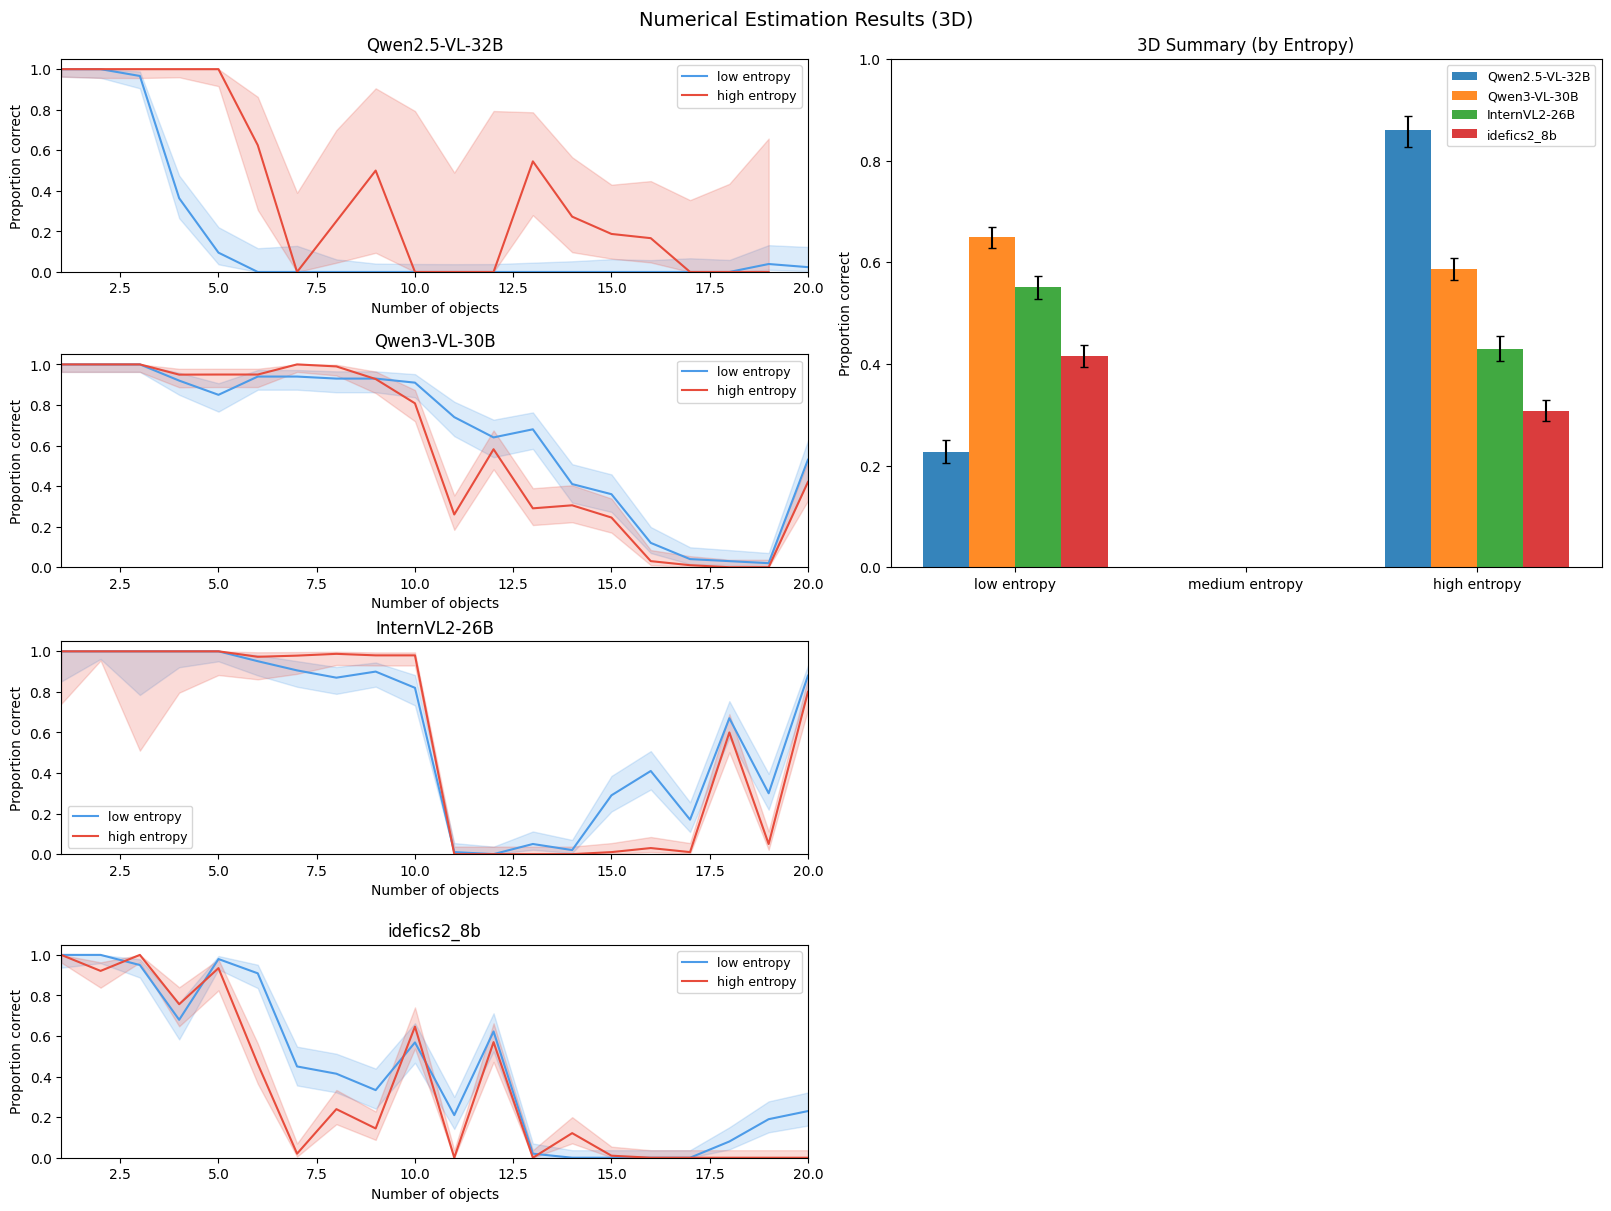

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ----------------------------
# Binomial 95% CI (Wilson)
# ----------------------------
def wilson_ci(k, n, z=1.96):
    k = np.asarray(k, dtype=float)
    n = np.asarray(n, dtype=float)
    low = np.zeros_like(k)
    high = np.zeros_like(k)

    mask = n > 0
    phat = np.zeros_like(k)
    phat[mask] = k[mask] / n[mask]

    denom = 1 + (z**2) / n[mask]
    center = (phat[mask] + (z**2) / (2*n[mask])) / denom
    half = (z / denom) * np.sqrt((phat[mask]*(1 - phat[mask]) + (z**2) / (4*n[mask])) / n[mask])

    low[mask] = np.clip(center - half, 0, 1)
    high[mask] = np.clip(center + half, 0, 1)
    return low, high


# ----------------------------
# Condition mapping + pooling
# ----------------------------
def map_entropy(lbl):
    if lbl == "low_entropy":
        return "low_entropy"
    if lbl == "high_entropy":
        return "high_entropy"
    if lbl in ("medium_entropy_same_shape", "medium_entropy_same_color"):
        return "medium_entropy"
    return None  # ignore control_distinct by default


def prepare_pooled(df_raw, model_name):
    df = df_raw.copy()
    df["model"] = model_name
    df["entropy_group"] = df["condition_label"].map(map_entropy)
    df = df[df["entropy_group"].notnull()].copy()

    # Pool duplicates by (model, entropy_group, n_objects)
    pooled = (
        df.groupby(["model", "entropy_group", "n_objects"], as_index=False)[["n_trials", "n_correct"]]
          .sum()
          .sort_values(["entropy_group", "n_objects"])
    )
    pooled["accuracy"] = pooled["n_correct"] / pooled["n_trials"]
    lo, hi = wilson_ci(pooled["n_correct"].values, pooled["n_trials"].values)
    pooled["ci_low"] = lo
    pooled["ci_high"] = hi
    return pooled


def summary_by_entropy(pooled_one_model):
    # Pool across n_objects -> single accuracy per entropy level for this model
    summ = (
        pooled_one_model.groupby(["model", "entropy_group"], as_index=False)[["n_trials", "n_correct"]]
                        .sum()
    )
    summ["accuracy"] = summ["n_correct"] / summ["n_trials"]
    lo, hi = wilson_ci(summ["n_correct"].values, summ["n_trials"].values)
    summ["ci_low"] = lo
    summ["ci_high"] = hi
    return summ


# ----------------------------
# Plotting
# ----------------------------
def plot_numerical_estimation(model_dfs, title="Numerical Estimation Results (3D)"):
    """Layout:
      - Left column: first 4 models (stacked line plots)
      - Right column: vertical summary bar chart (top) + last model line plot (bottom)
    """
    if not model_dfs:
        raise ValueError("model_dfs is empty")

    model_names = list(model_dfs.keys())
    n_models = len(model_names)

    pooled = {name: prepare_pooled(df, name) for name, df in model_dfs.items()}
    summ = pd.concat([summary_by_entropy(p) for p in pooled.values()], ignore_index=True)

    entropy_order = ["low_entropy", "medium_entropy", "high_entropy"]
    entropy_label = {
        "low_entropy": "low entropy",
        "medium_entropy": "medium entropy",
        "high_entropy": "high entropy",
    }

    cmap = plt.cm.get_cmap("tab10")
    model_colors = {name: cmap(i % 10) for i, name in enumerate(model_names)}

    entropy_line_colors = {
        "low_entropy": "#4C9BE8",
        "medium_entropy": "#3CB371",
        "high_entropy": "#E74C3C",
    }

    # ---- Decide who goes where (assumes 5 models: 4 left, 1 right) ----
    left_models = model_names[:4]
    right_model = model_names[4] if n_models >= 5 else (model_names[-1] if n_models else None)

    # ---- Figure + Grid ----
    # 4 rows total. Right column: bar spans rows 0-1, model spans rows 2-3
    fig = plt.figure(figsize=(16, 12), constrained_layout=True)
    gs = fig.add_gridspec(
        4, 2,
        width_ratios=[1.05, 1.0],
        height_ratios=[1, 1, 1, 1]
    )
    fig.suptitle(title, fontsize=14)

    # Left column axes (4 model plots)
    ax_left = [fig.add_subplot(gs[r, 0]) for r in range(4)]

    # Right column axes
    ax_bar = fig.add_subplot(gs[0:2, 1])       # top half
    ax_right_model = fig.add_subplot(gs[2:4, 1])  # bottom half

    # ---- Vertical summary bar chart ----
    x_base = np.arange(len(entropy_order))
    bar_w = 0.8 / max(n_models, 1)
    offsets = (np.arange(n_models) - (n_models - 1) / 2.0) * bar_w

    for i, model_name in enumerate(model_names):
        sub = summ[summ["model"] == model_name].set_index("entropy_group")

        accs, el, eh = [], [], []
        for g in entropy_order:
            a = float(sub.loc[g, "accuracy"]) if g in sub.index else np.nan
            lo = float(sub.loc[g, "ci_low"]) if g in sub.index else np.nan
            hi = float(sub.loc[g, "ci_high"]) if g in sub.index else np.nan
            accs.append(a)
            el.append(a - lo if np.isfinite(a) else np.nan)
            eh.append(hi - a if np.isfinite(a) else np.nan)

        x = x_base + offsets[i]
        ax_bar.bar(
            x,
            accs,
            width=bar_w,
            yerr=np.vstack([el, eh]),
            color=model_colors[model_name],
            alpha=0.9,
            capsize=3,
            label=model_name,
        )

    ax_bar.set_xticks(x_base)
    ax_bar.set_xticklabels([entropy_label[g] for g in entropy_order], rotation=0)
    ax_bar.set_ylim(0, 1.0)
    ax_bar.set_ylabel("Proportion correct")
    ax_bar.set_title("3D Summary (by Entropy)")
    ax_bar.legend(frameon=True, fontsize=9, ncol=1)

    # ---- Helper to draw one model line-plot into an axis ----
    def draw_model_lines(ax, model_name):
        p = pooled[model_name]
        for g in entropy_order:
            sub = p[p["entropy_group"] == g].sort_values("n_objects")
            if sub.empty:
                continue
            x = sub["n_objects"].values
            y = sub["accuracy"].values
            lo = sub["ci_low"].values
            hi = sub["ci_high"].values
            ax.plot(x, y, label=entropy_label[g], color=entropy_line_colors[g])
            ax.fill_between(x, lo, hi, color=entropy_line_colors[g], alpha=0.2)

        ax.set_xlim(1, 20)
        ax.set_ylim(0, 1.05)
        ax.set_xlabel("Number of objects")
        ax.set_ylabel("Proportion correct")
        ax.set_title(model_name)
        ax.legend(frameon=True, fontsize=9)

    # ---- Left column: up to 4 models ----
    for ax, m in zip(ax_left, left_models):
        draw_model_lines(ax, m)

    # Turn off unused left axes if <4 models
    for ax in ax_left[len(left_models):]:
        ax.axis("off")

    # ---- Right column bottom: remaining model (if exists) ----
    if right_model is not None and right_model not in left_models:
        draw_model_lines(ax_right_model, right_model)
    else:
        ax_right_model.axis("off")

    plt.savefig("./analysis/plots/numerical_estimation_tasks_3d.pdf", format="pdf", bbox_inches="tight")
    plt.show()


# ----------------------------
# Example usage
# ----------------------------
BASE = Path("analysis/results/3D")
model_paths = {
    "Qwen2.5-VL-32B": BASE / "Qwen2.5-VL-32B-Instruct-AWQ_counting.csv",
    "Qwen3-VL-30B": BASE / "qwen3-vl-30b-a3b-instruct_counting.csv",
    "InternVL2-26B": BASE / "InternVL2-26B_counting.csv",
    "idefics2_8b": BASE / "idefics2_8b_counting.csv",
}

model_dfs = {name: pd.read_csv(path) for name, path in model_paths.items()}
plot_numerical_estimation(model_dfs)


/tmp/ipykernel_7859/1532542160.py:94: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10")


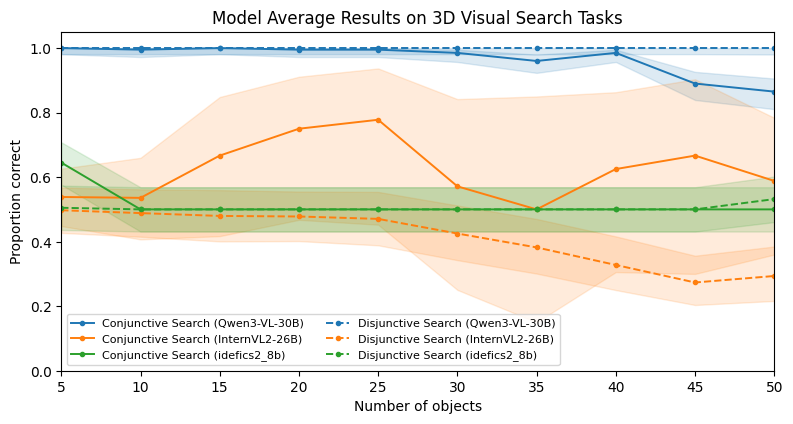

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ----------------------------
# Binomial 95% CI (Wilson)
# ----------------------------
def wilson_ci(k, n, z=1.96):
    k = np.asarray(k, dtype=float)
    n = np.asarray(n, dtype=float)
    low = np.zeros_like(k)
    high = np.zeros_like(k)

    mask = n > 0
    phat = np.zeros_like(k)
    phat[mask] = k[mask] / n[mask]

    denom = 1 + (z**2) / n[mask]
    center = (phat[mask] + (z**2) / (2*n[mask])) / denom
    half = (z / denom) * np.sqrt((phat[mask]*(1 - phat[mask]) + (z**2) / (4*n[mask])) / n[mask])

    low[mask] = np.clip(center - half, 0, 1)
    high[mask] = np.clip(center + half, 0, 1)
    return low, high


# ----------------------------
# Load + prepare visual-search results
# ----------------------------
def load_visual_search_csv(path, model_name):
    def empty_frame():
        return pd.DataFrame({
            "model": pd.Series(dtype=str),
            "condition_label": pd.Series(dtype=str),
            "n_objects": pd.Series(dtype=int),
            "n_trials": pd.Series(dtype=int),
            "n_correct": pd.Series(dtype=int),
            "accuracy": pd.Series(dtype=float),
            "ci_low": pd.Series(dtype=float),
            "ci_high": pd.Series(dtype=float),
        })

    df = pd.read_csv(path)
    if df.empty:
        out = empty_frame()
        out["model"] = out["model"].astype(str)
        return out

    df["model"] = model_name

    # Robust numeric parsing (some CSVs can be empty or have object dtypes)
    for col in ["n_objects", "n_trials", "n_correct"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    required = ["condition_label", "n_objects", "n_trials", "n_correct"]
    for col in required:
        if col not in df.columns:
            return empty_frame()

    df = df.dropna(subset=required).copy()
    if df.empty:
        return empty_frame()

    df["n_objects"] = df["n_objects"].astype(int)
    df["n_trials"] = df["n_trials"].astype(int)
    df["n_correct"] = df["n_correct"].astype(int)

    # Keep only main conditions (drop disjunctive_control unless you want it)
    df = df[df["condition_label"].isin(["disjunctive", "conjunctive"])].copy()
    if df.empty:
        return empty_frame()

    # Aggregate in case there are duplicates
    df = (
        df.groupby(["model", "condition_label", "n_objects"], as_index=False)[["n_trials", "n_correct"]]
          .sum()
          .sort_values(["condition_label", "n_objects"])
    )
    df["accuracy"] = (df["n_correct"] / df["n_trials"]).astype(float)
    lo, hi = wilson_ci(df["n_correct"].values, df["n_trials"].values)
    df["ci_low"] = lo.astype(float)
    df["ci_high"] = hi.astype(float)
    return df


def plot_visual_search_multi_models(df_all, title="Model Average Results on 3D Visual Search Tasks"):
    cond_order = ["conjunctive", "disjunctive"]
    cond_label = {"conjunctive": "Conjunctive Search", "disjunctive": "Disjunctive Search"}
    cond_style = {"conjunctive": "-", "disjunctive": "--"}

    models = list(df_all["model"].unique())
    cmap = plt.cm.get_cmap("tab10")
    model_colors = {m: cmap(i % 10) for i, m in enumerate(models)}

    fig, ax = plt.subplots(figsize=(9.2, 4.4))

    for cond in cond_order:
        for model in models:
            sub = df_all[(df_all["condition_label"] == cond) & (df_all["model"] == model)].sort_values("n_objects")
            if sub.empty:
                continue

            x = sub["n_objects"].to_numpy()
            y = sub["accuracy"].astype(float).to_numpy()
            lo = sub["ci_low"].astype(float).to_numpy()
            hi = sub["ci_high"].astype(float).to_numpy()

            color = model_colors[model]
            ax.plot(
                x,
                y,
                color=color,
                linestyle=cond_style[cond],
                marker="o",
                markersize=3,
                linewidth=1.4,
                label=f"{cond_label[cond]} ({model})",
            )
            ax.fill_between(x, lo, hi, color=color, alpha=0.15)

    ax.set_title(title)
    ax.set_xlabel("Number of objects")
    ax.set_ylabel("Proportion correct")
    ax.set_xlim(df_all["n_objects"].min(), df_all["n_objects"].max())
    ax.set_ylim(0.0, 1.05)
    ax.legend(frameon=True, fontsize=8, ncol=2)
    plt.savefig("./analysis/plots/visual_search_tasks_3d.pdf", format="pdf", bbox_inches="tight")
    plt.show()


# ----------------------------
# Paths (update if needed)
# ----------------------------
BASE = Path("analysis/results/3D")
model_paths = {
    "Qwen2.5-VL-32B": BASE / "Qwen2.5-VL-32B-Instruct-AWQ_visual_search.csv",
    "Qwen3-VL-30B": BASE / "qwen3-vl-30b-a3b-instruct_visual_search.csv",
    "InternVL2-26B": BASE / "InternVL2-26B_visual_search.csv",
    "idefics2_8b": BASE / "idefics2_8b_visual_search.csv",
}

all_dfs = [load_visual_search_csv(path, model_name=name) for name, path in model_paths.items()]
df_all = pd.concat(all_dfs, ignore_index=True)

plot_visual_search_multi_models(df_all)


/tmp/ipykernel_7859/4163055485.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10")


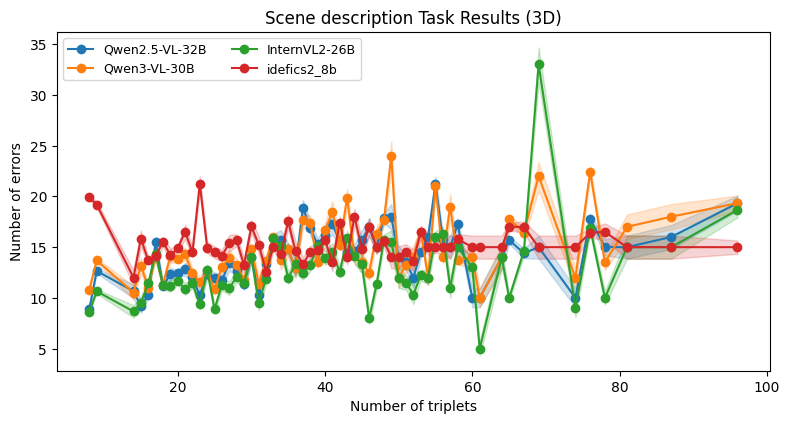

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ----------------------------
# Load + prep
# ----------------------------
def load_scene_desc(path, model_name):
    df = pd.read_csv(path)
    df["model"] = model_name

    # Aggregate in case of duplicates
    df = (
        df.groupby(["model", "gt_triplets"], as_index=False)[["n_trials", "mean_errors"]]
          .mean()  # mean_errors is already a mean; duplicates are unlikely, but safe
          .sort_values("gt_triplets")
    )
    return df


def add_approx_ci(df, z=1.96):
    """
    You only have mean_errors + n_trials (no std/sem), so we can't compute a true CI.
    As a lightweight stand-in (for a shaded band like the reference figure),
    we use a normal-approximation for the mean with an assumed Bernoulli-like bound:
        CI ~ mean ± z * sqrt(mean*(1-mean)/n)
    This is NOT statistically correct for edit-distance errors, but gives a small band.
    If you have per-example errors, replace this with the true SEM.
    """
    out = df.copy()
    # keep values non-negative for the sqrt; also avoid division by 0
    n = np.maximum(out["n_trials"].values.astype(float), 1.0)
    m = out["mean_errors"].values.astype(float)

    # Very small band fallback (so it still "looks" like the style)
    # Scale factor keeps band visible but not huge; adjust if you want.
    band = z * (np.sqrt(np.maximum(m, 1e-8)) / np.sqrt(n)) * 0.15

    out["ci_low"] = np.maximum(m - band, 0)
    out["ci_high"] = m + band
    return out


# ----------------------------
# Plot (style like your example)
# ----------------------------
def plot_scene_description(dfs, title="Scene description Task Results (3D)"):
    models = [df["model"].iloc[0] for df in dfs]
    cmap = plt.cm.get_cmap("tab10")
    colors = {m: cmap(i % 10) for i, m in enumerate(models)}

    fig, ax = plt.subplots(figsize=(9.2, 4.4))

    for df in dfs:
        model = df["model"].iloc[0]
        df = df.sort_values("gt_triplets")
        x = df["gt_triplets"].values
        y = df["mean_errors"].values
        lo = df["ci_low"].values
        hi = df["ci_high"].values

        ax.plot(x, y, marker="o", linewidth=1.5, label=model, color=colors[model])
        ax.fill_between(x, lo, hi, color=colors[model], alpha=0.2)

    ax.set_title(title)
    ax.set_xlabel("Number of triplets")
    ax.set_ylabel("Number of errors")
    ax.legend(frameon=True, fontsize=9, ncol=2)
    plt.savefig("./analysis/plots/scene_description_tasks_3d.pdf", format="pdf", bbox_inches="tight")
    plt.show()


# ----------------------------
# Paths
# ----------------------------
BASE = Path("analysis/results/3D")
model_paths = {
    "Qwen2.5-VL-32B": BASE / "Qwen2.5-VL-32B-Instruct-AWQ_scene_description.csv",
    "Qwen3-VL-30B": BASE / "qwen3-vl-30b-a3b-instruct_scene_description.csv",
    "InternVL2-26B": BASE / "InternVL2-26B_scene_description.csv",
    "idefics2_8b": BASE / "idefics2_8b_scene_description.csv",
}

all_dfs = [add_approx_ci(load_scene_desc(path, name)) for name, path in model_paths.items()]

# NOTE: shaded bands are approximate unless you have per-trial error distributions
plot_scene_description(all_dfs)
